# Проект для «Викишоп» с BERT

## Содержание
* 1  Подготовка
* 2  Обучение
* 3 Тестирование

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1 Подготовка

In [177]:
'''%pip install transformers
%pip install catboost
%pip install seaborn'''

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выводим значения float до 3 знаков после запятой
import torch
import transformers as ppb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
from tqdm import notebook
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle # для перемешивания данных
import time

In [179]:
pd.options.display.max_colwidth = 500 # выведем побольше символов в ячейках

In [180]:
#from google.colab import drive
#drive.mount('/content/drive')

In [181]:
df = pd.read_csv('/datasets/toxic_comments.csv')
#df = pd.read_csv('toxic_comments.csv')
df.head(20)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


Приведем алгоритм проведения классификации с помощью Embeddings:
1. Проводится предобработка текста:
2. Выполняется токенизация каждого текста, то есть его разбивают на слова;
3. Проводится лемматизация, если используется не BERT;
4. Текст очищается от стоп-слов и ненужных символов;
5. Для корректной работы алгоритма добавляют маркеры начала и конца предложения (они приравниваются к токенам).
6. На выходе у каждого исходного текста образуется свой список токенов.
7. Токены передают модели, которая переводит их в векторные представления. Для этого модель обращается к составленному заранее словарю токенов. На выходе для каждого текста образуются векторы заданной длины.
8. На финальном этапе модели передают признаки (векторы). И она прогнозирует эмоциональную окраску текста — 0 («отрицательная») или 1 («положительная»).

Начнем с предобработки текста. Оставим только слова, состоящие из букв.

In [182]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clear_text = ' '.join(clear_text)
    return(clear_text)

In [183]:
df['text'] = df['text'].apply(clear_text)

Приведем текст к нижнему регистру.

In [184]:
df['text'] = df['text'].str.lower()
df.head()

,text,toxic
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0
1,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0
2,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay u...,0
4,you sir are my hero any chance you remember what page that s on,0


In [185]:
df.duplicated().sum()

1293

Избавимся от дубликатов.

In [186]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Исследуем соотношение классов.

0   0.898
1   0.102
Name: toxic, dtype: float64


<AxesSubplot:>

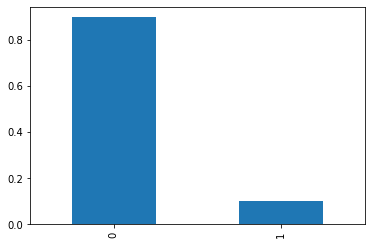

In [187]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Гистограмма показала, что классы не сбалансированы. После подготовки эмбеддингов необходимо будет провести ликвидацию дисбаланса.

Т.к. выданный заказчиком датасет достаточно велик, для создания его ембеддингов понадобятся значительные вычислительные мощности. В виду отсутствия данных мощностей, выберем 17000 случайных строк для выполнения проекта с сохранением исходного дисбаланса классов. Чтобы сохранить выявленный дисбаланс классов, применим метод train_test_split.

In [188]:
df_rest, df_1 = train_test_split(df, test_size=17000, random_state=12345)
df_1.shape

(17000, 2)

Проведем токенизацию текстов.

In [189]:
def make_embeddings(features):
  model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

  # Загрузка предобученной модели/токенизатора 
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)

  tokenized= features.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
      max_len = len(i)

  padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  batch_size = 100

  embeddings = []
  for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
      batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  final_features = np.concatenate(embeddings)
  final_features = pd.DataFrame(final_features)
  return final_features

In [190]:
features = make_embeddings(df_1['text'])

In [191]:
target = df_1['toxic'].reset_index(drop=True)

In [192]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
features, target, test_size=0.4, stratify=target, random_state=12345) # разделили выборки в пропорции 4 к 10

features_test, features_valid, target_test, target_valid = train_test_split(
features_valid_test, target_valid_test, test_size=0.5, stratify=target_valid_test, random_state=12345) # разделили вал-ую и тестовую пополам

In [193]:
print(features_train.shape)
print(features_test.shape)

(10200, 768)
(3400, 768)


In [194]:
target_train.value_counts()

0    9203
1     997
Name: toxic, dtype: int64

In [195]:
features_train.shape

(10200, 768)

In [196]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [197]:
repeat=10
features_train, target_train = upsample(features_train, target_train, repeat)
print(features_train.shape)
print(target_train.value_counts())

(19173, 768)
1    9970
0    9203
Name: toxic, dtype: int64


Данные подготовлены, переходим к обучению моделей.

## 2 Обучение моделей

### Логистическая регрессия

In [198]:
%%time
best_model = None
best_result = 0
best_с = 0
for reg in np.linspace(0.0001, 100, 20):
    model = LogisticRegression(random_state=12345, solver='liblinear', C=reg)
    model.fit(features_train, target_train) # обучаем модель на обучающей выборке
    predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
    result = f1_score(target_valid, predictions) # посчитаем качество модели
    print(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_с = reg
print('Наилучшее качество модели {:.3f} при регуляризации {}'.format(best_result, best_с))

0.48126561199000834
0.6206088992974239
0.6214285714285714
0.6235011990407674
0.6216867469879517
0.6224366706875754
0.6207729468599035
0.6198547215496368
0.6181818181818182
0.6150121065375301
0.6135265700483092
0.6150121065375301
0.6150121065375301
0.612590799031477
0.6140776699029127
0.6133333333333334
0.6140776699029127
0.6155717761557178
0.614823815309842
0.614823815309842
Наилучшее качество модели 0.624 при регуляризации 15.789557894736841
CPU times: user 15min 48s, sys: 8.45 s, total: 15min 57s
Wall time: 15min 50s


Наилучшее значение метрики F1 для логистической регрессии на валидационной выборке, равное 0.68, было получено для регуляризации равной 10.526405263157894

### Случайный лес

In [199]:
%%time
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_split = 0
for est in range(10, 101, 10):
    for depth in range (1, 9):
        for spl in (2, 7):
            model = RandomForestClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     max_depth=depth, min_samples_split = spl) # инициализируем модель
            model.fit(features_train, target_train) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_split = spl

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth,
     "Минимальное количество примеров для разделения", best_split)

0.4280215550423403
0.4280215550423403
0.4926739926739926
0.4926739926739926
0.5263157894736842
0.5263157894736842
0.5321463897131552
0.5321463897131552
0.5659574468085106
0.5659574468085106
0.6113033448673586
0.6113033448673586
0.6146220570012392
0.6155747836835599
0.6164021164021165
0.6259946949602122
0.47796610169491527
0.47796610169491527
0.5189289012003693
0.5189289012003693
0.535819430814524
0.535819430814524
0.5376128385155466
0.5376128385155466
0.5783898305084746
0.5783898305084746
0.6135831381733021
0.608187134502924
0.6270543615676358
0.6200762388818297
0.6594594594594596
0.659400544959128
0.45928338762214976
0.45928338762214976
0.5223048327137546
0.5223048327137546
0.5441906653426017
0.5441906653426017
0.5549949545913219
0.5549949545913219
0.5837837837837838
0.5837837837837838
0.6235294117647059
0.6213364595545136
0.6434108527131783
0.6435006435006435
0.6583679114799448
0.654696132596685
0.4679802955665025
0.4679802955665025
0.5162488393686165
0.5162488393686165
0.54223968565

Наилучшее значение метрики F1 для случайного леса, равное 0.675, было получено для следующих параметров: {'max_depth': 8, 'n_estimators': 100, min_samples_split: 2}

### LightGBM

In [200]:
best_model = None
best_result = 0
best_est = 0
best_leaves = 0
best_rate = 0
for est in [50, 100, 500]:
    for leave in [21, 31, 41, 51]:
        for rate in [0.01, .04, 0.06, 0.3]:
            model = LGBMClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     num_leaves=leave, learning_rate = rate) # инициализируем модель
            model.fit(features_train, target_train) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_leaves = leave
                best_rate = rate

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Скорость обучения:", best_rate,
     "Количество листьев", best_leaves)

0.5260170293282876
0.6036036036036037
0.6356033452807647
0.6726998491704375
0.5513078470824949
0.6221692491060786
0.6514575411913814
0.6666666666666667
0.5533262935586062
0.6422250316055627
0.6567967698519517
0.6721044045676998
0.5614035087719299
0.637215528781794
0.6666666666666666
0.6655231560891939
0.5750262329485835
0.654320987654321
0.6631439894319683
0.6849757673667204
0.588495575221239
0.6640106241699867
0.691114245416079
0.6789915966386554
0.5965317919075144
0.6563814866760168
0.6706056129985228
0.6916524701873935
0.6099635479951397
0.6666666666666666
0.6877828054298643
0.6690265486725663
0.6624203821656052
0.6984126984126985
0.6993464052287581
0.6836734693877551
0.6823204419889503
0.6988352745424293
0.6836734693877551
0.6827586206896552
0.6831395348837209
0.6883561643835616
0.682842287694974
0.6952054794520549
0.6696296296296297
0.682842287694974
0.6666666666666666
0.6830985915492958
F1 наилучшей модели на валидационной выборке: 0.6993464052287581 Количество деревьев: 500 Скор

Наилучшее значение метрики F1 для LGBM, равное 0.699, было получено для следующих параметров: {'num_leaves': 21, 'n_estimators': 500, 'learning_rate': 0.06}

### CatBoost

In [201]:
best_model = None
best_result = 0
best_iter = 0
best_rate = 0
for iter in [150, 500]:
  for rate in [0.01, .04, 0.06, 0.3, 0.5]:
    model = CatBoostClassifier(random_state=12345, 
                                     iterations=iter, learning_rate = rate) # инициализируем модель
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
    print(result)
    if result > best_result:
      best_model = model
      best_result = result
      best_iter = iter
      best_rate = rate

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество иттераций:", best_iter, "Скорость обучения:", best_rate)

0:	learn: 0.6862852	total: 233ms	remaining: 34.7s
1:	learn: 0.6785215	total: 379ms	remaining: 28s
2:	learn: 0.6704216	total: 526ms	remaining: 25.8s
3:	learn: 0.6631750	total: 667ms	remaining: 24.3s
4:	learn: 0.6556436	total: 823ms	remaining: 23.9s
5:	learn: 0.6486985	total: 966ms	remaining: 23.2s
6:	learn: 0.6420059	total: 1.12s	remaining: 22.9s
7:	learn: 0.6352422	total: 1.28s	remaining: 22.7s
8:	learn: 0.6289013	total: 1.42s	remaining: 22.3s
9:	learn: 0.6212276	total: 1.57s	remaining: 22s
10:	learn: 0.6148641	total: 1.72s	remaining: 21.7s
11:	learn: 0.6088759	total: 1.86s	remaining: 21.4s
12:	learn: 0.6028769	total: 2.01s	remaining: 21.2s
13:	learn: 0.5968946	total: 2.16s	remaining: 21s
14:	learn: 0.5916774	total: 2.32s	remaining: 20.9s
15:	learn: 0.5857538	total: 2.47s	remaining: 20.7s
16:	learn: 0.5801415	total: 2.62s	remaining: 20.5s
17:	learn: 0.5745384	total: 2.77s	remaining: 20.3s
18:	learn: 0.5693242	total: 2.91s	remaining: 20.1s
19:	learn: 0.5644349	total: 3.07s	remaining: 19

Наилучшее значение метрики F1 для CatBoost, равное 0.68285, было получено для следующих параметров:{'learning_rate': 0.06, 'iterations': 500}

Посмотрим какой показатель возможно получить на тесте.

## 3 Тестирование

In [202]:
# создадим таблицу для хранения результатов
d = {'model': [], 'F_1':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,F_1,fit_time,predict_time


In [203]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model):
    f_1, fit_time, pred_time = ml(model)
    results.loc[len(results)] = [model_name, f_1, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [204]:
# cоздадим функцию для расчета необходимых параметров
def ml (model):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    f_1 = f1_score(target_test, predictions)
    
    return f_1, fit_time, pred_time

In [205]:
# логистическая регрессия
lr = LogisticRegression(random_state=12345, solver='liblinear', C=10.526405263157894)
model_res('LogisticRegression', lr)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.665,28.537,0.007


In [206]:
# случайный лес
rf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=12345, min_samples_split=2)
model_res('RandomForestClassifier', rf)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.665,28.537,0.007
1,RandomForestClassifier,0.693,23.892,0.060


In [207]:
# Light GBM
lgbm = LGBMClassifier(learning_rate=0.06, n_estimators=500, num_leaves=21, random_state=12345)
model_res('LGBMClassifier', lgbm)
display(results)

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.665,28.537,0.007
1,RandomForestClassifier,0.693,23.892,0.060
2,LGBMClassifier,0.752,74.845,0.201


In [208]:
# CatBoost
cb = CatBoostClassifier(learning_rate=0.06, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostClassifier', cb)
display(results)

0:	learn: 0.6535447	total: 144ms	remaining: 1m 12s
1:	learn: 0.6065038	total: 289ms	remaining: 1m 11s
2:	learn: 0.5750709	total: 438ms	remaining: 1m 12s
3:	learn: 0.5451903	total: 583ms	remaining: 1m 12s
4:	learn: 0.5194353	total: 731ms	remaining: 1m 12s
5:	learn: 0.4968233	total: 876ms	remaining: 1m 12s
6:	learn: 0.4758499	total: 1.02s	remaining: 1m 12s
7:	learn: 0.4571605	total: 1.17s	remaining: 1m 12s
8:	learn: 0.4414394	total: 1.32s	remaining: 1m 11s
9:	learn: 0.4269645	total: 1.47s	remaining: 1m 11s
10:	learn: 0.4125071	total: 1.61s	remaining: 1m 11s
11:	learn: 0.4012159	total: 1.75s	remaining: 1m 11s
12:	learn: 0.3899085	total: 1.9s	remaining: 1m 11s
13:	learn: 0.3807209	total: 2.05s	remaining: 1m 11s
14:	learn: 0.3718384	total: 2.19s	remaining: 1m 11s
15:	learn: 0.3629243	total: 2.34s	remaining: 1m 10s
16:	learn: 0.3544469	total: 2.49s	remaining: 1m 10s
17:	learn: 0.3464058	total: 2.62s	remaining: 1m 10s
18:	learn: 0.3390003	total: 2.77s	remaining: 1m 10s
19:	learn: 0.3324911	to

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.665,28.537,0.007
1,RandomForestClassifier,0.693,23.892,0.060
2,LGBMClassifier,0.752,74.845,0.201
3,CatBoostClassifier,0.740,71.169,0.079


In [209]:
results

,model,F_1,fit_time,predict_time
0,LogisticRegression,0.665066,28.537223,0.007405
1,RandomForestClassifier,0.693481,23.892425,0.059992
2,LGBMClassifier,0.752026,74.845248,0.200540
3,CatBoostClassifier,0.740181,71.168883,0.078726



## ВЫВОД
Целевая метрика побита с помощью LGBMClassifier. Поставленную задачу можно считать выполненной.